2018 Sep 24<br>
Exploring the use of BEER_curve

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import bindata, transit_duration
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
K76 = Kepler76_params()

In [13]:
# 2018 Sep 5 - As a way of minimizing compute time while maximizing the eclipse signal, 
#   I'll take a binsize of 30-min and a boxcar window size equal to one orbital period.
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846894


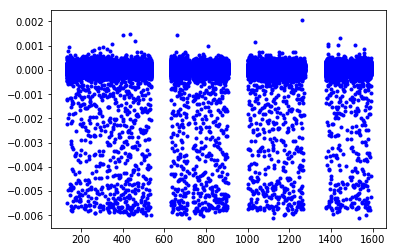

In [14]:
# Initial fit using Faigler's parameters (with my own T0)
plt.plot(filtered_time, filtered_flux, 'b.')

CPU times: user 159 ms, sys: 50.4 ms, total: 209 ms
Wall time: 211 ms


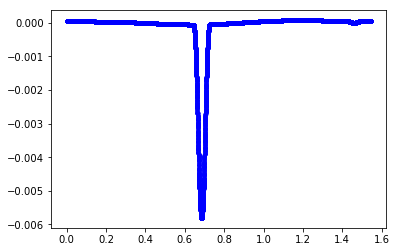

In [15]:
BC = BEER_curve(folded_time, K76.saved_params, supersample_factor=10, exp_time=30./60./24.)
%time plt.plot(folded_time, BC.all_signals(), 'b.')

In [16]:
def fit_sinusoids(cur_time, cur_p, cur_b, cur_T0, cur_Aellip, cur_Abeam, cur_F0, cur_Aplanet, cur_phase_shift):
    params = K76.saved_params.copy()
    
    params['p'] = cur_p
    params['b'] = cur_b
    params['T0'] = cur_T0
    params['Aellip'] = cur_Aellip
    params['Abeam'] = cur_Abeam
    params['F0'] = cur_F0
    params['Aplanet'] = cur_Aplanet
    params['phase_shift'] = cur_phase_shift
    
    cur_BC = BEER_curve(cur_time, params, supersample_factor=10, exp_time=30./60./24.)
    
    return cur_BC.all_signals()

[0.09683257918552035, 0.944, 0.68508434, 2.11e-05, 1.35e-05, 0.0, 5.04e-05, -0.02861111111111111]
CPU times: user 27.1 s, sys: 8.36 s, total: 35.5 s
Wall time: 32.9 s
[ 1.04967660e-01  9.58786962e-01  6.84991344e-01  1.26174046e-05
 -3.04648864e-05  3.21516787e-05  6.15699667e-05 -1.14438336e-01]
[6.29453254e-04 1.03039116e-03 1.94911620e-05 1.00651199e-06
 2.05702829e-04 1.28031641e-06 1.35497891e-04 4.00116640e-01]
(138.81791567384016, -2.449197236098879)


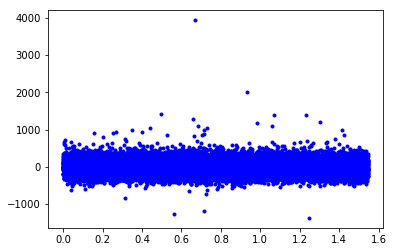

In [20]:
# Estimate scatter
ind = ~transit_indices(folded_time, K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])

time = folded_time
data = filtered_flux
err = unbinned_noise*np.ones_like(folded_time)

initial_guess = [K76.saved_params['p'], K76.saved_params['b'], K76.saved_params['T0'],
                 K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['F0'], 
                 K76.saved_params['Aplanet'], K76.saved_params['phase_shift']]
print(initial_guess)
%time popt, pcov = curve_fit(fit_sinusoids, time, data, sigma=unbinned_noise*np.ones_like(time), p0=initial_guess, bounds=([0., -1, K76.saved_params['T0']*0.95, -500e-6, -500e-6, -500e-6, -500e-6, -1], [0.2, 1., K76.saved_params['T0']*1.05, 500e-6, 500e-6, 500e-6, 500e-6, 1]))
print(popt)
print(np.sqrt(pcov.diagonal()))

# plt.plot(time, data, 'b.')
# plt.plot(time, fit_sinusoids(time, *popt), 'r.')

resid = data - fit_sinusoids(time, *popt)
plt.plot(time, resid*1e6, 'b.')
#plt.ylim([-700, 700])

overall_popt = popt
overall_pcov = pcov
unbinned_noise = mad(resid)

print(mad(resid)*1e6, np.median(resid)*1e6)

944
5.0


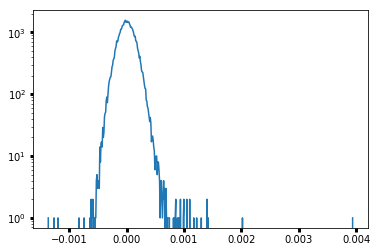

In [160]:
# 2018 Oct 3 - Explore how white the noise is
hst, bin_edges = np.histogram(resid, bins='auto')
plt.semilogy(bin_edges[1:], hst)

num_orbs = int((np.max(filtered_time) - np.min(filtered_time))/saved_params['per'])
print(num_orbs)
desired_SNR = 1.
num_to_fold = np.ceil((desired_SNR*mad(resid)/(overall_popt[5] + overall_popt[6]))**2.)
print(num_to_fold)

In [100]:
def fit_eclipse(cur_time, cur_Aellip, cur_Abeam, cur_F0, cur_Aplanet, cur_phase_shift):
    params = saved_params.copy()
    
    params['Aellip'] = cur_Aellip
    params['Abeam'] = cur_Abeam
    params['F0'] = cur_F0
    params['Aplanet'] = cur_Aplanet
    params['phase_shift'] = cur_phase_shift
    
    cur_BC = BEER_curve(cur_time, params, supersample_factor=10, exp_time=30./60./24.)
    
    return cur_BC.all_signals()

# From http://astropython.blogspot.com/2012/02/computing-chi-squared-and-reduced-chi.html
def redchisqg(ydata,ymod,deg,sd):  
    """
    Returns the reduced chi-square error statistic for an arbitrary model,   
    chisq/nu, where nu is the number of degrees of freedom. If individual   
    standard deviations (array sd) are supplied, then the chi-square error   
    statistic is computed as the sum of squared errors divided by the standard   
    deviations. See http://en.wikipedia.org/wiki/Goodness_of_fit for reference.  

    ydata,ymod,sd assumed to be Numpy arrays. deg integer.  

    Usage:  
    >>> chisq=redchisqg(ydata,ymod,n,sd)  
    where  
    ydata : data  
    ymod : model evaluated at the same x points as ydata  
    n : number of free parameters in the model  
    sd : uncertainties in ydata  

    Rodrigo Nemmen  
    http://goo.gl/8S1Oo  
    """ 
    # Chi-square statistic  
    chisq=np.sum( ((ydata-ymod)/sd)**2 )  
             
    # Number of degrees of freedom assuming 2 free parameters  
    nu=ydata.size-1-deg  
        
    return chisq/nu 

[260.87939205]
13.660731931781974


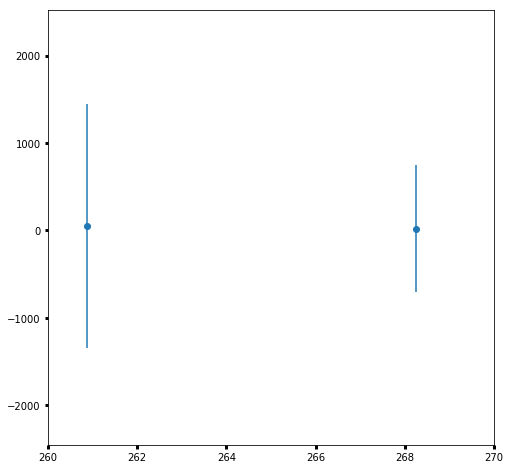

In [174]:
# 2018 Oct 3 - Trying now to fit eclipses, num_to_fold at a time
dur = transit_duration(saved_ep)
TE = saved_params['T0'] + 0.5*saved_params['per']

sampling = 30./60./24.
num_points_in_eclipse = num_to_fold#*int(np.ceil(dur/sampling))

mn = np.min(filtered_time) + saved_params['per']
mx = np.min(filtered_time) + saved_params['per'] + num_to_fold*saved_params['per']

# men_times = np.array([])
# popts = {}
# pcovs = {}
# while(mx < np.max(filtered_time) - num_to_fold*saved_params['per']):
# # while(mx < np.min(filtered_time) + num_to_fold*saved_params['per'] + 100.*saved_params['per']):
# #while(mx <= np.min(filtered_time) + saved_params['per'] + num_to_fold*saved_params['per']):
#     ind = (filtered_time >= mn) & (filtered_time < mx)
    
#     time = filtered_time[ind] % saved_params['per']
#     data = filtered_flux[ind]
#     err = unbinned_noise*np.ones_like(time)
    
#     # Check that the eclipse occurs inside the time range
#     eclipse_ind = np.abs(time - TE) < 0.5*dur
    
#     if(time[eclipse_ind].size >= num_points_in_eclipse):
#         try:
#             initial_guess = [saved_params['Aellip'], saved_params['Abeam'], saved_params['F0'], 
#                              saved_params['Aplanet'], saved_params['phase_shift']]
#             popt, pcov = curve_fit(fit_eclipse, time, data, sigma=err, 
#                                    p0=initial_guess, 
#                                    bounds=([-500e-6, -500e-6, -500e-6, -500e-6, -1], 
#                                            [500e-6, 500e-6, 500e-6, 500e-6, 1]))

#             men_time = np.mean(filtered_time[ind])
#             men_times = np.append(men_times, men_time)
#             popts[men_time] = popt

#             # Re-scale by reduced chi-squared
#             model = fit_eclipse(time, *popt)
#             chisq = redchisqg(data, model, 5, err)
#             pcovs[men_time] = pcov*chisq

#             print(men_time, chisq)
#         except:
#             pass
# #         print(popt)
# #         print(np.sqrt(pcov.diagonal()))
# #         print
    
#     mn += num_to_fold*saved_params['per']
#     mx += num_to_fold*saved_params['per']

plt.figure(figsize=(8,8))

# ind = saved_y/saved_err > 3
# plt.errorbar(saved_x[ind], saved_y[ind]*1e6, saved_err[ind]*1e6, marker='o', color='red', ls='')

# ind = folded_19_y/folded_19_err > 3
# plt.errorbar(folded_19_x[ind], folded_19_y[ind]*1e6, folded_19_err[ind]*1e6, marker='o', color='black', ls='')
    
x = men_times
y = np.array([popts[key][2] + popts[key][3] for key in men_times])
err = np.array([np.sqrt(pcovs[key][2,2] + pcovs[key][3,3] + 2*pcovs[key][2,3]*pcovs[key][3,2])
                for key in men_times])

ind = y/err > 0
x = x[ind]
y = y[ind]
err = err[ind]
plt.errorbar(x, y*1e6, err*1e6, marker='o', ls='')
plt.xlim([260, 270])
print(men_times[(men_times < 262) & (men_times > 260)])

mn_ind = np.argmin(y)
mx_ind = np.argmax(y)

print((y[mx_ind] - y[mn_ind])/np.sqrt(err[mx_ind]**2. + err[mn_ind]**2.))

# saved_x = x
# saved_y = y
# saved_err = err

# folded_19_x = x
# folded_19_y = y
# folded_19_err = err

(0, 100)

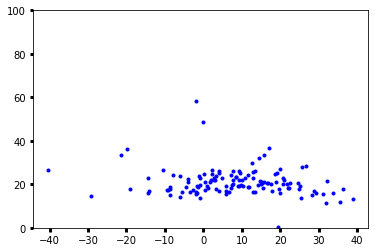

In [188]:
x = np.array([popts[key][0] for key in men_times])
y = np.array([np.sqrt(pcovs[key][2,2] + pcovs[key][3,3] + 2*pcovs[key][2,3]*pcovs[key][3,2])
                for key in men_times])

plt.plot(x*1e6, y*1e6, 'b.')
plt.ylim([0, 100])

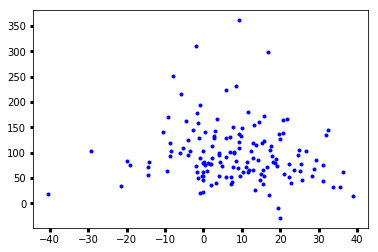

In [189]:
x = np.array([popts[key][0] for key in men_times])
y = np.array([popts[key][2] + popts[key][3] for key in men_times])

plt.plot(x*1e6, y*1e6, 'b.')

[ 3.03686598e-10  6.57595226e-06  3.14800428e-05  2.12415448e-05
 -7.52438696e-02]
0.001395671364109898


(-0.001, 0.001)

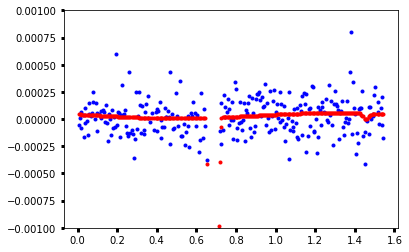

In [191]:
key = 260.87939205458554
print(popts[key])
print(np.sqrt(pcovs[key][2,2] + pcovs[key][3,3] + 2*pcovs[key][2,3]*pcovs[key][3,2]))

ind = (filtered_time >= key - 0.5*num_to_fold*saved_params['per']) &\
        (filtered_time < key + 0.5*num_to_fold*saved_params['per'])

time = filtered_time[ind] % saved_params['per']
data = filtered_flux[ind]
plt.plot(time, data, 'b.')
plt.plot(time, fit_eclipse(time, *popts[key]), 'r.')

#plt.ylim([-0.001, 0.001])

3.199108034440729


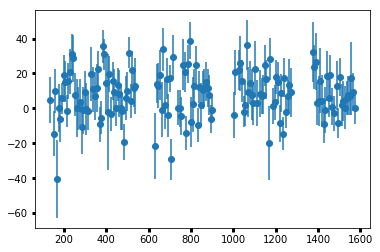

In [166]:
x = men_times
y = np.array([popts[key][0] for key in men_times])
err = np.array([np.sqrt(pcovs[key][0,0]) for key in men_times])

plt.errorbar(x, y*1e6, err*1e6, marker='o', ls='')

mn_ind = np.argmin(y)
mx_ind = np.argmax(y)

print((y[mx_ind] - y[mn_ind])/np.sqrt(err[mx_ind]**2. + err[mn_ind]**2.))

2018 Sep 28<br>
Experimenting to make sure BEER curve can recover variable eclipses.

5.89345269342667e-05


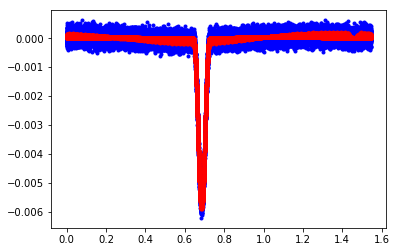

In [8]:
# 2018 Sep 28 - Just as a check, let's try a more complicated behavior.
# Now I'd like to make the eclipse depth vary sinusoidally from orbit to orbit, stack the eclipses all together,
# and see what eclipse depth I get.
which_orbit = np.floor((filtered_time - Faigler_T0)/saved_params['per'])
which_orbit -= np.min(which_orbit)
which_orbit_unq = np.unique(which_orbit)
which_orbit_midtime = which_orbit_unq*saved_params['per']

eclipse_variability_period = 10.*saved_params['per'] # eclipse depth will vary with a period equal to 10 orbits
eclipse_variability_amplitude = saved_params['F0'] + saved_params['Aplanet']
eclipse_depths = np.abs(eclipse_variability_amplitude + normal(size=len(which_orbit_midtime), 
                                                         scale=eclipse_variability_amplitude))

synthetic_times = np.array([])
synthetic_eclipses = np.array([])
noisy_synthetic_eclipses = np.array([])
for i in range(len(which_orbit_unq)-1):
    mn = which_orbit_unq[i]*saved_ep.per + np.min(filtered_time)
    mx = (which_orbit_unq[i] + 1)*saved_ep.per + np.min(filtered_time)
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    
    if(filtered_time[ind].size > 0):
    
        synthetic_times = np.append(synthetic_times, filtered_time[ind])
        cur_Aplanet = eclipse_depths[i] - saved_params['F0']

        cur_eclipse = fit_sinusoids(filtered_time[ind] % saved_params['per'], 
                                    saved_params['p'], saved_params['b'], saved_params['T0'], 
                                    saved_params['Aellip'], saved_params['Abeam'], 
                                    saved_params['F0'], cur_Aplanet, saved_params['phase_shift'])
        synthetic_eclipses = np.append(synthetic_eclipses, cur_eclipse)

        noisy_synthetic_eclipses = np.append(noisy_synthetic_eclipses, 
                                             cur_eclipse + normal(size=len(cur_eclipse), 
                                                                  scale=unbinned_noise))

    
plt.plot(synthetic_times % saved_params['per'], noisy_synthetic_eclipses, 'b.')
plt.plot(synthetic_times % saved_params['per'], synthetic_eclipses, 'r.')
#plt.xlim([1.4, 1.5])

men = np.mean(eclipse_depths)
print(men)